Get Dynamic Word Embeddings

```
# code from dynamic word embedding paper

import scipy.io as sio
import numpy as np
import json
from pprint import pprint
from scipy.spatial.distance import pdist
#%%


word = 'communist'


wordlist = []
fid = open('data/wordlist.txt','r')
for line in fid:
    wordlist.append(line.strip())
fid.close()
nw = len(wordlist)
    
word2Id = {}
for k in xrange(len(wordlist)):
    word2Id[wordlist[k]] = k


times = range(180,200) # total number of time points (20/range(27) for ngram/nyt)

emb_all = sio.loadmat('results/embeddings.mat')

#%%

nn = 50
nc = 5
emb = emb_all['U_%d' % times.index(199)]
             
X = []
list_of_words = []
isword = []
v = emb[word2Id[word],:]
for year in times:


    emb = emb_all['U_%d' % times.index(year)]
    embnrm = np.reshape(np.sqrt(np.sum(emb**2,1)),(emb.shape[0],1))
    emb_normalized = np.divide(emb, np.tile(embnrm, (1,emb.shape[1])))           
    print emb_normalized.shape
    v = emb_normalized[word2Id[word],:]




    d =np.dot(emb_normalized,v)
    
    idx = np.argsort(d)[::-1]
    newwords = [(wordlist[k], year) for k in list(idx[:nn])]
    print newwords
    list_of_words.extend(newwords)
    for k in xrange(nn):
        isword.append(k==0)
    X.append(emb[idx[:nn],:])
    #print year, [wordlist[i] for i in idx[:nn]]
    
X = np.vstack(X)

print X.shape

#%%

from sklearn.manifold import TSNE
model = TSNE(n_components=2, metric = 'euclidean')
Z = model.fit_transform(X)


#%%



allwords = ['art','damn','gay','hell','maid','muslim']

import matplotlib.pyplot as plt
import pickle

plt.clf()
traj = []
for k in xrange(len(list_of_words)):
    
    if isword[k] :
        marker = 'ro'
        traj.append(Z[k,:])
    else: marker = 'b.'
    
    
    plt.plot(Z[k,0], Z[k,1],marker)
    plt.text(Z[k,0], Z[k,1],list_of_words[k])

traj = np.vstack(traj)
plt.plot(traj[:,0],traj[:,1])
plt.show()

sio.savemat('tsne_output/%s_tsne.mat'%word,{'emb':Z})
pickle.dump({'words':list_of_words,'isword':isword},open('tsne_output/%s_tsne_wordlist.pkl'%word,'wb'))

#%%
allwords = ['art','damn','gay','hell','maid','muslim']

import matplotlib.pyplot as plt
import pickle
Z = sio.loadmat('tsne_output/%s_tsne.mat'%word)['emb']
data = pickle.load(open('tsne_output/%s_tsne_wordlist.pkl'%word,'rb'))
list_of_words, isword = data['words'],data['isword']
plt.clf()
traj = []


Zp = Z*1.
Zp[:,0] = Zp[:,0]*2.
all_dist = np.zeros((Z.shape[0],Z.shape[0]))
for k in xrange(Z.shape[0]):
    all_dist[:,k] =np.sum( (Zp - np.tile(Zp[k,:],(Z.shape[0],1)))**2.,axis=1)

dist_to_centerpoints = all_dist[:,isword]
dist_to_centerpoints = np.min(dist_to_centerpoints,axis=1)

dist_to_other = all_dist + np.eye(Z.shape[0])*1000.
idx_dist_to_other = np.argsort(dist_to_other,axis=1)
dist_to_other = np.sort(dist_to_other,axis=1)

plt.clf()
for k in xrange(len(list_of_words)-1,-1,-1):
    
    if isword[k] :
        #if list_of_words[k][1] % 3 != 0 and list_of_words[k][1] < 199 : continue
        marker = 'bo'
        traj.append(Z[k,:])
        plt.plot(Z[k,0], Z[k,1],marker)
    else: 
        if dist_to_centerpoints[k] > 200: continue
        skip =False
        for i in xrange(Z.shape[0]):
            if dist_to_other[k,i] < 150 and idx_dist_to_other[k,i] > k: 
                skip = True
                break
            if dist_to_other[k,i] >= 150: break
        
        if skip: continue
        if Z[k,0] > 8: continue
        plt.plot(Z[k,0], Z[k,1])
    
    
    plt.text(Z[k,0]-2, Z[k,1]+np.random.randn()*2,' %s-%d' % (list_of_words[k][0], list_of_words[k][1]*10))

plt.axis('off')
traj = np.vstack(traj)
plt.plot(traj[:,0],traj[:,1])
plt.show()
```

In [1]:
import numpy as np
import json
from pprint import pprint
from scipy.spatial.distance import pdist
# word2vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

#%%

In [2]:
# adapt above code to our data
word = "addiction"

# wordlist is the entire vocabulary
wordlist = []

# create a dictionary word2Id where each word in the wordlist is mapped to a unique ID.
# word2Id = {}
# for k in range(len(wordlist)):
#     word2Id[wordlist[k]] = k

times = range(2013, 2023)

# load word embeddings
emb_all = {}
path = "output/models/word2vec_drug_"
for t in times:
    # skip 2015 and 2021
    if t != 2015 and t != 2021:
        emb_all['U_%d' % t] = np.load(path + str(t) + ".model.wv.vectors.npy")

        # get vocabulary from model
        model = Word2Vec.load(path + str(t) + ".model")
        vocab = list(model.wv.key_to_index.keys())
        # get word2Id
        word2Id = {}
        for k in range(len(vocab)):
            word2Id[vocab[k]] = k 
        # get wordlist
        wordlist = vocab
    else:
        pass

# nearest neighbors for tsne plot
nn = 10
# number of clusters
nc = 5
emb = emb_all['U_2013']

In [22]:
# embeddings are in the format of a dictionary
# get normalized vector representation of each word per year

# initializes an empty list X to store the selected word embeddings and a list list_of_words to store the words and corresponding years.
X = []
list_of_words = []
isword = []
v = emb[word2Id[word],:]

for year in times:
    # not 2015 and 2021
    if year != 2015 and year != 2021:
        emb = emb_all['U_%d' % year]
        # normalize the embeddings
        # normalizes the word embeddings and retrieves the embedding vector for the specified word at the latest time point.
        embnrm = np.reshape(np.sqrt(np.sum(emb**2,1)),(emb.shape[0],1))
        emb_normalized = np.divide(emb, np.tile(embnrm, (1,emb.shape[1])))
        # add to dictionary
        # embeddings[year] = emb_normalized
        print(emb_normalized.shape)

        v = emb_normalized[word2Id[word],:]

        d =np.dot(emb_normalized,v)
        idx = np.argsort(d)[::-1]
        # For each time point in times, it calculates the similarity between the word embedding and other embeddings using dot product and stores the nearest neighbors.
        newwords = [wordlist[k] for k in idx[:nn]]
        print(newwords)
        list_of_words.extend(newwords)
        for k in range(nn):
            isword.append(k==0)
        # The selected word embeddings and corresponding words are added to the X and list_of_words lists.
        X.append(emb[idx[:nn],:])

# The X list is converted into a NumPy array.
X = np.vstack(X)
print(X.shape)


(40458, 300)
['addiction', 'saying', '…', 'medical', 'annual', 'philadelphia', 'fear', 'said,', 'department', 'biggest']
(35929, 300)
['addiction', 'effects', '2018,', 'recalled', 'charges,', 'annual', 'charged', 'clean', 'spokesperson', 'offered']
(39019, 300)
['addiction', 'including', 'filed', 'local', 'treat', 'records', '2020,', 'national', 'heart', 'women']
(47665, 300)
['addiction', 'regulated', 'safer', 'cause', 'wage', 'xylazine', 'continues', 'convention', 'figures', 'billion']
(48512, 300)
['addiction', 'abuse', 'businesses,', 'public.', '“i', 'slow', 'heroin', 'expand', 'american', 'porter']
(48015, 300)
['addiction', 'student', 'college', 'says', 'film', 'leaders', 'spent', 'green', 'pick', 'native']
(36209, 300)
['addiction', 'cannabis', 'use', 'said', 'marijuana', 'said.', 'said,', 'including', 'pennsylvania', '“i']
(35407, 300)
['addiction', 'treatment', 'drug', 'drugs', 'buprenorphine', 'access', 'people', 'treat', 'medication', 'opioid']
(80, 300)


In [23]:
from sklearn.manifold import TSNE
# The t-SNE algorithm is applied to reduce the dimensionality of the word embeddings to 2 dimensions.
model = TSNE(n_components=2, metric = 'euclidean')
Z = model.fit_transform(X)

/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


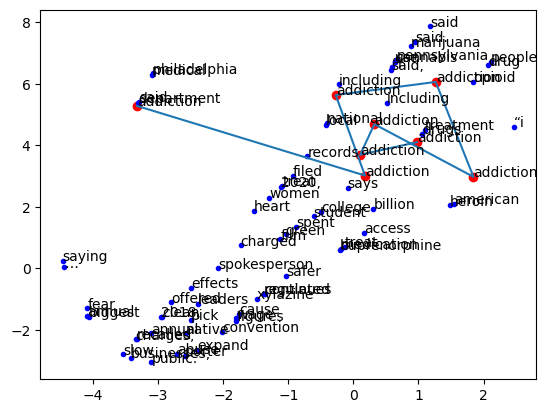

In [24]:
allwords = ["addiction", "heroin", "methadone", "marijuana", "treatment", "harm"]

# For each word in the list_of_words, it plots the word's position on the t-SNE plot.

import matplotlib.pyplot as plt
import pickle

plt.clf()
traj = []
for k in range(len(list_of_words)):
    # Words belonging to the word category are marked as red circles, while others are marked as blue dots.
    if isword[k] :
        marker = 'ro'
        traj.append(Z[k,:])
    else: marker = 'b.'
    
    
    plt.plot(Z[k,0], Z[k,1],marker)
    plt.text(Z[k,0], Z[k,1],list_of_words[k])

traj = np.vstack(traj)
plt.plot(traj[:,0],traj[:,1])
plt.show()

pickle.dump({'words':list_of_words,'isword':isword},open('output/tsne_output/%s_tsne_wordlist.pkl'%word,'wb'))

In [3]:
allwords = ["addiction", "heroin", "methadone", "marijuana", "treatment", "harm"]

import matplotlib.pyplot as plt
import pickle
# The code loads the t-SNE embeddings and the list_of_words and isword data from the saved files.
data = pickle.load(open('output/tsne_output/%s_tsne_wordlist.pkl'%word,'rb'))
list_of_words, isword = data['words'],data['isword']
plt.clf()
traj = []

# computes the distances between all word embeddings and the distances to the center points (words) separately.
Zp = Z*1.
Zp[:,0] = Zp[:,0]*2.
all_dist = np.zeros((Z.shape[0],Z.shape[0]))
for k in range(Z.shape[0]):
    all_dist[:,k] =np.sum( (Zp - np.tile(Zp[k,:],(Z.shape[0],1)))**2.,axis=1)

dist_to_centerpoints = all_dist[:,isword]
dist_to_centerpoints = np.min(dist_to_centerpoints,axis=1)

dist_to_other = all_dist + np.eye(Z.shape[0])*1000.
idx_dist_to_other = np.argsort(dist_to_other,axis=1)
dist_to_other = np.sort(dist_to_other,axis=1)

plt.clf()
# For each word in the list_of_words, it plots the word's position on the t-SNE plot with specific conditions.
for k in range(len(list_of_words)-1,-1,-1):
    
    if isword[k] :
        #if list_of_words[k][1] % 3 != 0 and list_of_words[k][1] < 199 : continue
        # Words belonging to the word category are marked as blue circles, while others are plotted as lines.
        marker = 'bo'
        traj.append(Z[k,:])
        plt.plot(Z[k,0], Z[k,1],marker)
    else: 
        if dist_to_centerpoints[k] > 200: continue
        skip =False
        for i in range(Z.shape[0]):
            if dist_to_other[k,i] < 150 and idx_dist_to_other[k,i] > k: 
                skip = True
                break
            if dist_to_other[k,i] >= 150: break
        
        if skip: continue
        if Z[k,0] > 8: continue
        plt.plot(Z[k,0], Z[k,1])
    
    
    plt.text(Z[k,0]-2, Z[k,1]+np.random.randn()*2,list_of_words[k])

plt.axis('off')
traj = np.vstack(traj)
plt.plot(traj[:,0],traj[:,1])
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'output/tsne_output/addiction_tsne_wordlist.pkl'

---

### Make refresh visualization

In [47]:
# normalize embedding vectors for each word for each year
# get nearest neighbors for each word for each year
# get t-SNE embeddings for each word for each year
# print nearest neighbors for each word for each year
# plot t-SNE embeddings for each word for each year
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# load embeddings
path = "output/models/word2vec_drug_"
# define seed terms and years
# seed_terms = ["addiction", "heroin", "methadone", "marijuana", "treatment", "harm"]
seed_terms = ["addiction"]
years = range(2013, 2023)
models = {}
for year in years:
    models[year] = Word2Vec.load(path + str(year) + ".model")

In [61]:
vectors = []
labels = []
neighbors = []
years_list = []
for term in seed_terms:
    for year in years:
        if term in models[year].wv.key_to_index:
            vectors.append(models[year].wv[term])
            labels.append(f'{term}{year}')
            years_list.append(year)
            similar_words = models[year].wv.most_similar(term, topn=3)
            neighbors.append(similar_words[0][0])

In [62]:
# Normalize vectors
scaler = StandardScaler()
vectors_normalized = scaler.fit_transform(vectors)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
vectors_tsne = tsne.fit_transform(vectors_normalized)

/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


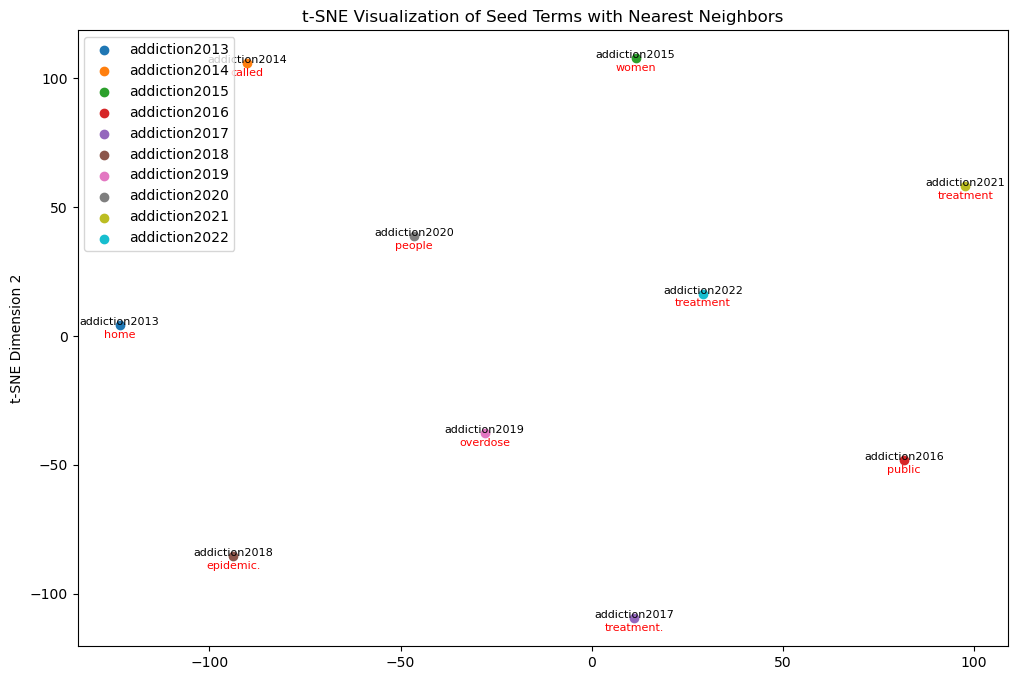

In [63]:
plt.figure(figsize=(12, 8))
for i, label in enumerate(labels):
    x, y = vectors_tsne[i]
    plt.scatter(x, y, label=label)
    plt.annotate(label, (x, y), fontsize=8, ha='center')
    plt.annotate(neighbors[i], (x, y-5), fontsize=8, ha='center', color='red')

# Set x-axis ticks and labels
# plt.xticks(np.arange(len(years)), years_list, rotation=45)

# plt.xlabel('Year')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Seed Terms with Nearest Neighbors')
plt.legend()
plt.show()

/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


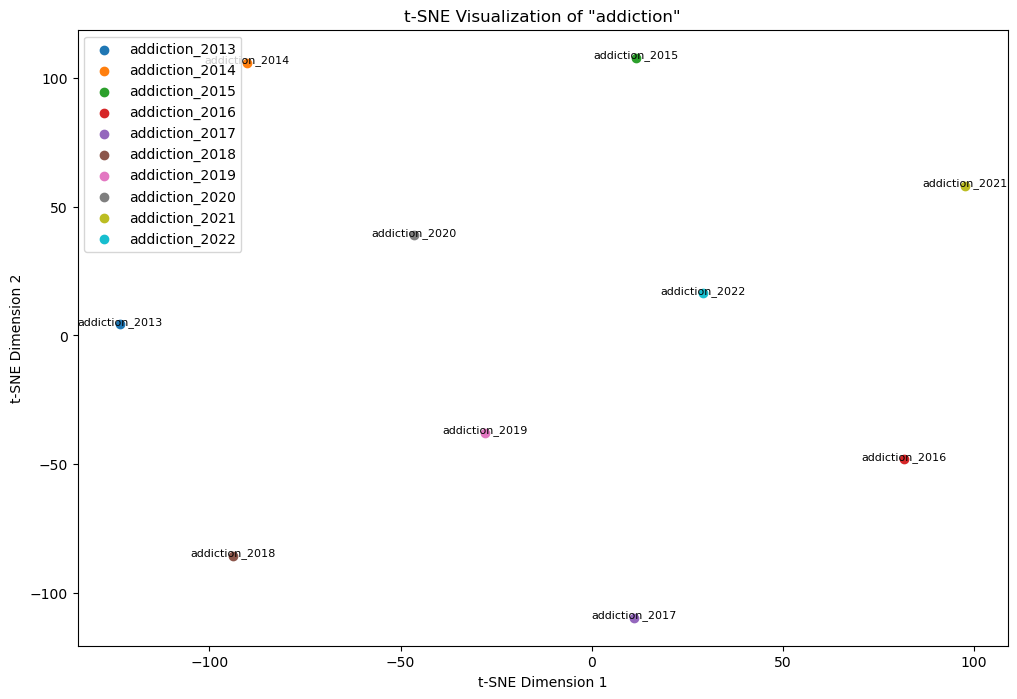

/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


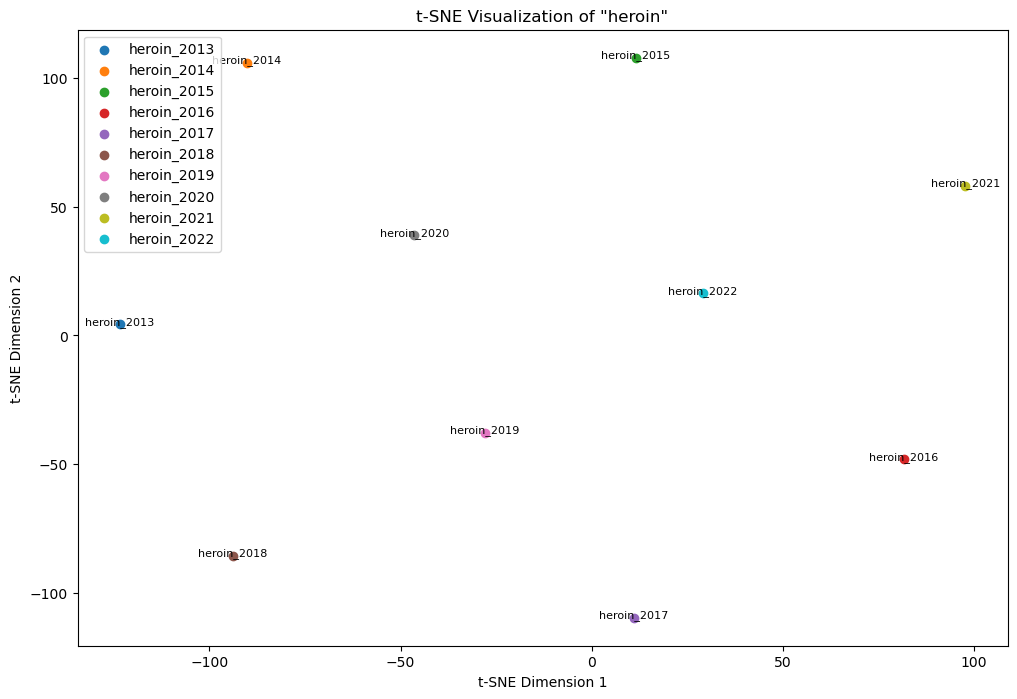

/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


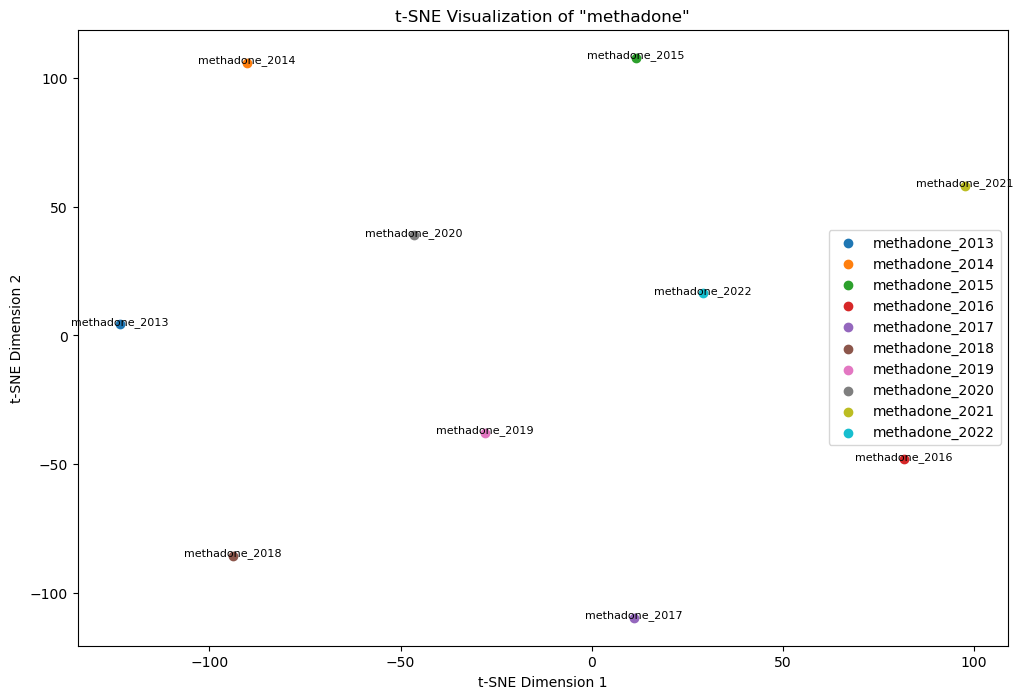

/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


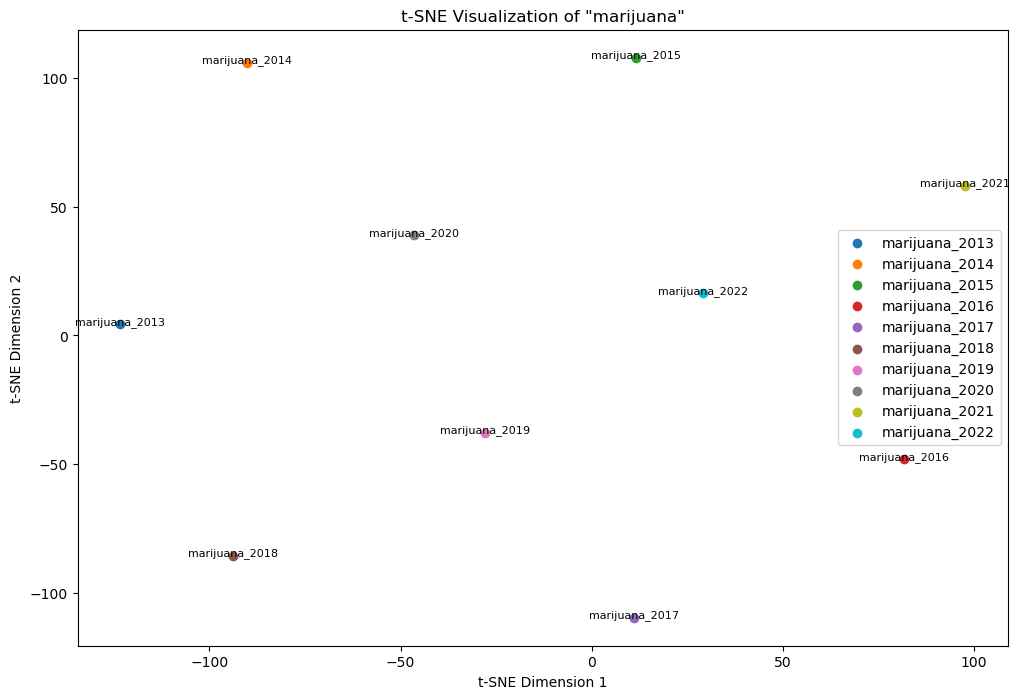

/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


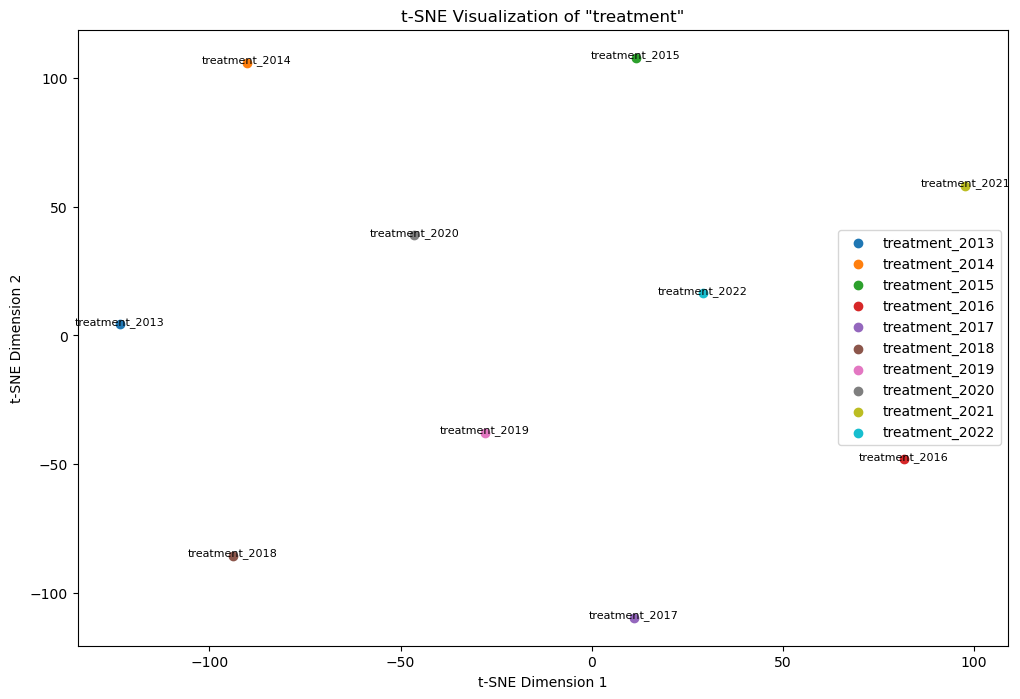

/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


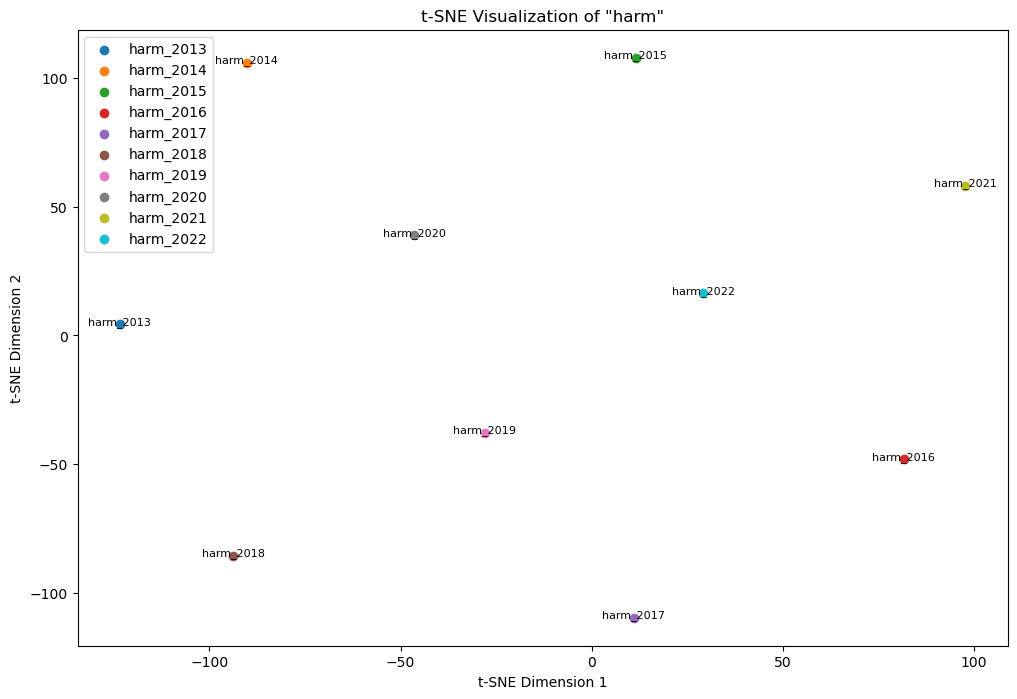

In [43]:
# Perform t-SNE dimensionality reduction and create separate plots for each seed term
for term in seed_terms:
    vectors = []
    labels = []
    
    # Collect word vectors for each seed term for each year
    for year in years:
        if term in models[year].wv.key_to_index:
            vectors.append(models[year].wv[term])
            labels.append(f'{term}_{year}')
    
    # Normalize vectors
    scaler = StandardScaler()
    vectors_normalized = scaler.fit_transform(vectors)
    
    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    vectors_tsne = tsne.fit_transform(vectors_normalized)
    
    # Plot the t-SNE results for the current seed term
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(labels):
        x, y = vectors_tsne[i]
        plt.scatter(x, y, label=label)
        plt.annotate(label, (x, y), fontsize=8, ha='center')
    
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title(f't-SNE Visualization of "{term}"')
    plt.legend()
    plt.show()